Installing packages required to work with Azure ML studio

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [2]:
travel_churn_data = pd.read_csv('data/CustomerTravel_org.csv')

travel_churn_data.head()

Age FrequentFlyer AnnualIncomeClass  ServicesOpted  \
0   34            No     Middle Income              6   
1   34           Yes        Low Income              5   
2   37            No     Middle Income              3   
3   30            No     Middle Income              2   
4   30            No        Low Income              1   

  AccountSyncedToSocialMedia BookedHotelOrNot  Target  
0                         No              Yes       0  
1                        Yes               No       1  
2                        Yes               No       0  
3                         No               No       0  
4                         No               No       0

In [3]:
travel_churn_data.shape

(954, 7)

In [4]:
travel_churn_data.columns

Index(['Age', 'FrequentFlyer', 'AnnualIncomeClass', 'ServicesOpted',
       'AccountSyncedToSocialMedia', 'BookedHotelOrNot', 'Target'],
      dtype='object')

In [5]:
travel_churn_data = travel_churn_data.drop_duplicates()
travel_churn_data.shape

(447, 7)

In [6]:
travel_churn_data['Target'].value_counts()

0    325
1    122
Name: Target, dtype: int64

In [7]:
travel_churn_data['AnnualIncomeClass'].unique()

array(['Middle Income', 'Low Income', 'High Income'], dtype=object)

In [8]:
mapper = {'Low Income': 0,'Middle Income': 1, 'High Income': 2}

In [9]:
travel_churn_data['AnnualIncomeClass'] = travel_churn_data['AnnualIncomeClass'].replace(mapper)

In [10]:
categorical_features = ['FrequentFlyer','AccountSyncedToSocialMedia', 'BookedHotelOrNot']
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown = 'ignore', drop = 'first'))])
preprocessor = ColumnTransformer(transformers = [('cat_tr', categorical_transformer, categorical_features)], 
                                 remainder = StandardScaler())

In [11]:
X = travel_churn_data.drop(labels = ['Target'], axis = 1)
 
y = travel_churn_data['Target']
 
from sklearn.model_selection import train_test_split
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 124)

Logistic Regression Model is trained and parameters and metrics are logged.
We can display the display the logged parameters and metrics inside the notebook using report='notebook'.
We can generate markdown reports also using report='md'. First of all, we will run LR model with default parameters. Then we will set the class_weight parameter to balanced.When we do metrics comparison, Recall score is improved for 'balanced' LR model

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


# DVC Report

params.yaml

|   C | class_weight   | dual   | fit_intercept   |   intercept_scaling | l1_ratio   |   max_iter | multi_class   | n_jobs   | penalty   | random_state   | solver   |    tol |   verbose | warm_start   |
|-----|----------------|--------|-----------------|---------------------|------------|------------|---------------|----------|-----------|----------------|----------|--------|-----------|--------------|
|   1 |                | False  | True            |                   1 |            |        100 | auto          |          | l2        |                | lbfgs    | 0.0001 |         0 | False        |

metrics.json

|   Train_accuracy_score |   Test_accuracy_score |   Test_precision_score |   Test_recall_score |   Test_f1_score |   AUC_score |
|------------------------|-----------------------|------------------------|---------------------|-----------------|-------------|
|               0.792717 |              0.733333 |                    0.5 |            0.333333 |             0.4 |    0.756629 |

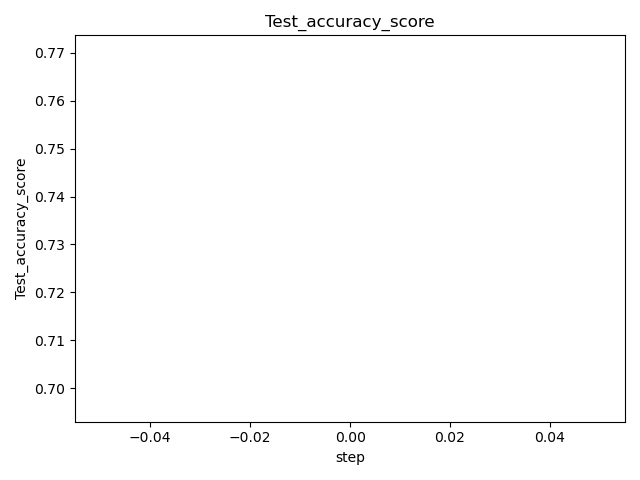

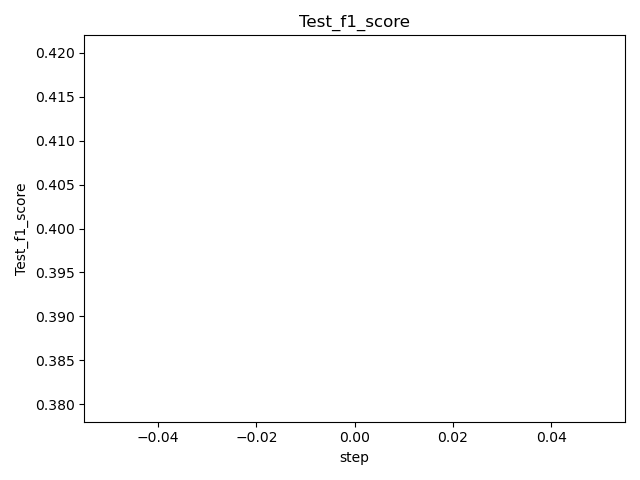

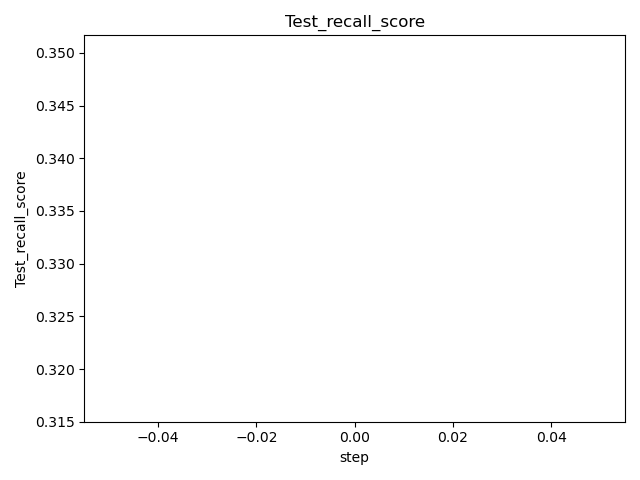

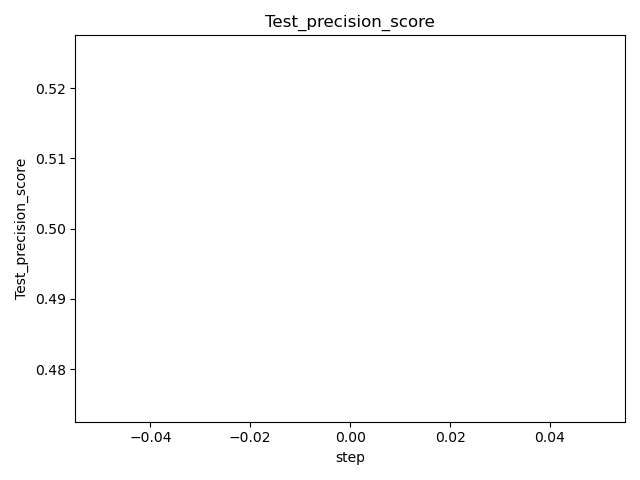

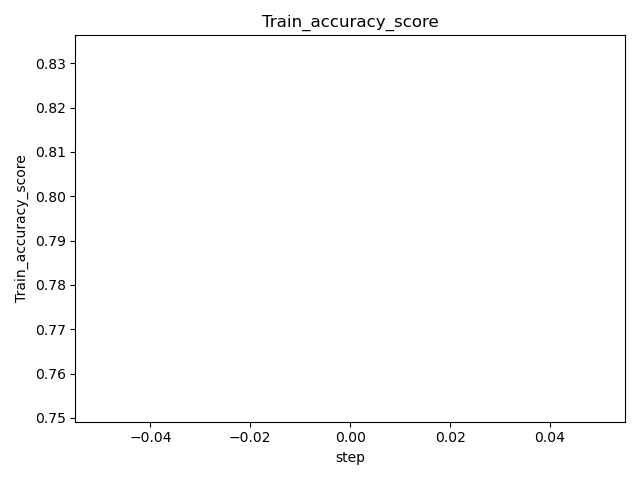

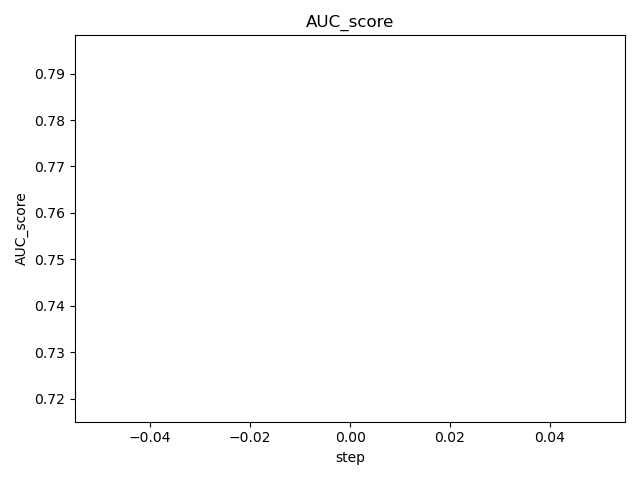



	.DS_Store, dvc_plots/index.html, .ipynb_checkpoints/demo-01-ChurnPrediction-checkpoint.ipynb, data/Customertravel_org.csv
/Users/loonycorn/anaconda3/lib/python3.10/site-packages/dvc_render/vega.py:98: UserWarning: `generate_markdown` can only be used with `LinearTemplate`
  warn("`generate_markdown` can only be used with `LinearTemplate`")


In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from dvclive import Live
lr_model = LogisticRegression()
#lr_model = LogisticRegression(class_weight = 'balanced')
    
pipe_lr = Pipeline(steps = [('preprocessor', preprocessor), ('classifier', lr_model)])
model_params = lr_model.get_params()
print(model_params)
pipe_lr.fit(X_train, y_train)
 
predictions = pipe_lr.predict(X_test)
predictions_predict_prob = pipe_lr.predict_proba(X_test)
    
train_accuracy_score = pipe_lr.score(X_train, y_train)
test_accuracy_score = accuracy_score(y_test, predictions)
test_precision_score = precision_score(y_test, predictions)
test_recall_score = recall_score(y_test, predictions)
test_f1_score = f1_score(y_test, predictions)
auc_score = roc_auc_score(y_test,  predictions_predict_prob[:, 1])
    
metrics = {
        'Train_accuracy_score': train_accuracy_score, 
        'Test_accuracy_score': test_accuracy_score,
        'Test_precision_score': test_precision_score,
        'Test_recall_score': test_recall_score,
        'Test_f1_score': test_f1_score,
        'AUC_score': auc_score }
    
with Live(save_dvc_exp = True, report = 'notebook', exp_message = 'LogisticRegressionClassifier') as live:
    live.log_params(model_params)
        
    live.log_metric('Train_accuracy_score',train_accuracy_score)
    live.log_metric('Test_accuracy_score',test_accuracy_score)
    live.log_metric('Test_precision_score', test_precision_score)
    live.log_metric('Test_recall_score', test_recall_score)
    live.log_metric('Test_f1_score', test_f1_score)
    live.log_metric('AUC_score', auc_score)
    
    live.log_sklearn_plot('confusion_matrix', y_test, predictions, name = 'cm.json')
    

{'C': 1.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


# DVC Report

params.yaml

|   C | class_weight   | dual   | fit_intercept   |   intercept_scaling | l1_ratio   |   max_iter | multi_class   | n_jobs   | penalty   | random_state   | solver   |    tol |   verbose | warm_start   |
|-----|----------------|--------|-----------------|---------------------|------------|------------|---------------|----------|-----------|----------------|----------|--------|-----------|--------------|
|   1 | balanced       | False  | True            |                   1 |            |        100 | auto          |          | l2        |                | lbfgs    | 0.0001 |         0 | False        |

metrics.json

|   Train_accuracy_score |   Test_accuracy_score |   Test_precision_score |   Test_recall_score |   Test_f1_score |   AUC_score |
|------------------------|-----------------------|------------------------|---------------------|-----------------|-------------|
|               0.711485 |              0.722222 |               0.482759 |            0.583333 |        0.528302 |    0.751578 |

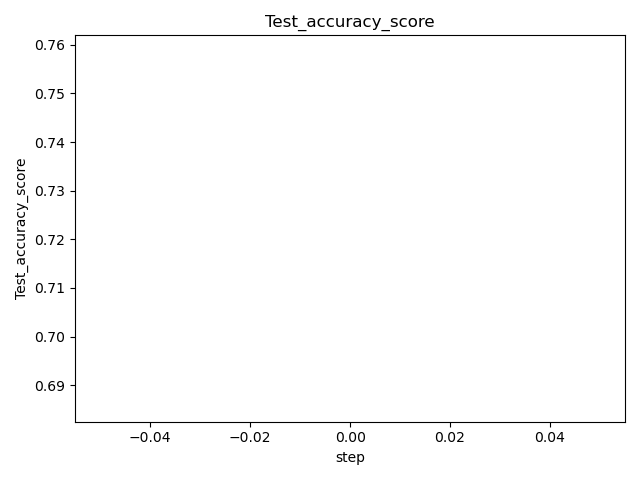

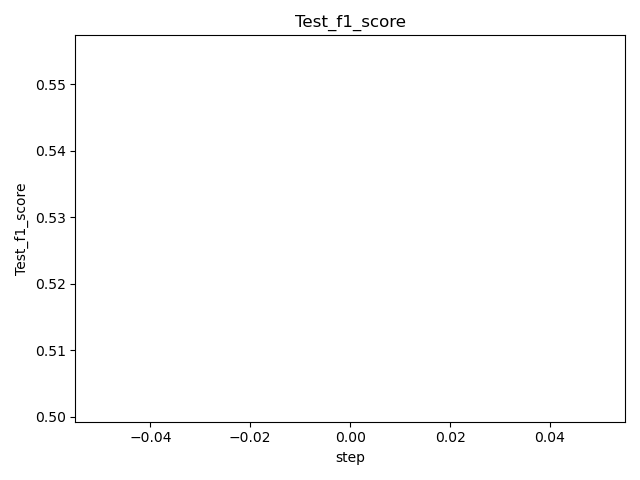

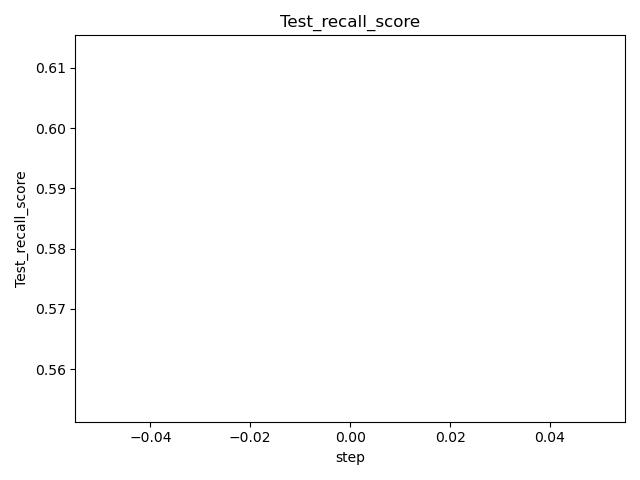

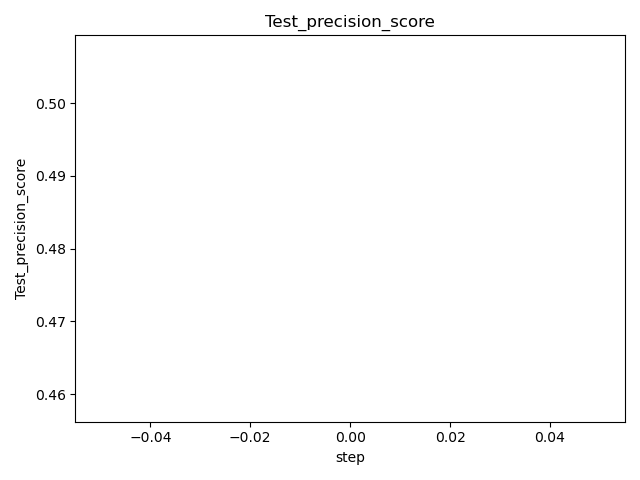

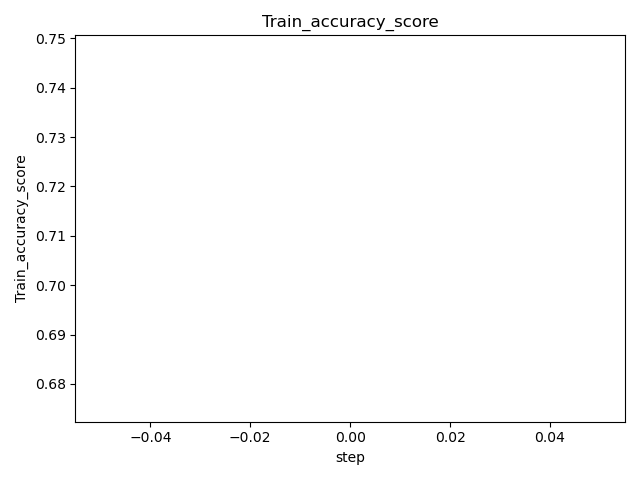

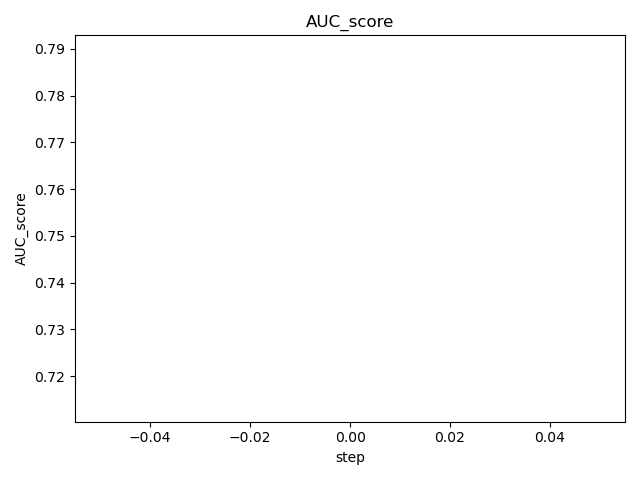



	.DS_Store, dvc_plots/index.html, .ipynb_checkpoints/demo-01-ChurnPrediction-checkpoint.ipynb, data/Customertravel_org.csv
/Users/loonycorn/anaconda3/lib/python3.10/site-packages/dvc_render/vega.py:98: UserWarning: `generate_markdown` can only be used with `LinearTemplate`
  warn("`generate_markdown` can only be used with `LinearTemplate`")


In [64]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from dvclive import Live
#lr_model = LogisticRegression()
lr_model = LogisticRegression(class_weight = 'balanced')
    
pipe_lr = Pipeline(steps = [('preprocessor', preprocessor), ('classifier', lr_model)])
model_params = lr_model.get_params()
print(model_params)
pipe_lr.fit(X_train, y_train)
 
predictions = pipe_lr.predict(X_test)
predictions_predict_prob = pipe_lr.predict_proba(X_test)
    
train_accuracy_score = pipe_lr.score(X_train, y_train)
test_accuracy_score = accuracy_score(y_test, predictions)
test_precision_score = precision_score(y_test, predictions)
test_recall_score = recall_score(y_test, predictions)
test_f1_score = f1_score(y_test, predictions)
auc_score = roc_auc_score(y_test,  predictions_predict_prob[:, 1])
    
metrics = {
        'Train_accuracy_score': train_accuracy_score, 
        'Test_accuracy_score': test_accuracy_score,
        'Test_precision_score': test_precision_score,
        'Test_recall_score': test_recall_score,
        'Test_f1_score': test_f1_score,
        'AUC_score': auc_score }
    
with Live(save_dvc_exp = True, report = 'notebook', exp_message = 'LogisticRegressionClassifier_balanced_class_weight') as live:
    live.log_params(model_params)
        
    live.log_metric('Train_accuracy_score',train_accuracy_score)
    live.log_metric('Test_accuracy_score',test_accuracy_score)
    live.log_metric('Test_precision_score', test_precision_score)
    live.log_metric('Test_recall_score', test_recall_score)
    live.log_metric('Test_f1_score', test_f1_score)
    live.log_metric('AUC_score', auc_score)
    
    live.log_sklearn_plot('confusion_matrix', y_test, predictions, name = 'cm.json')
    

RandomForest Model is trained and parameters and metrics are logged.It can easily seen that this experiment's performance is quite better than Logistic Regression Experiment.


{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


# DVC Report

params.yaml

| bootstrap   |   ccp_alpha | class_weight   | criterion   | max_depth   | max_features   | max_leaf_nodes   | max_samples   |   min_impurity_decrease |   min_samples_leaf |   min_samples_split |   min_weight_fraction_leaf |   n_estimators | n_jobs   | oob_score   | random_state   |   verbose | warm_start   |
|-------------|-------------|----------------|-------------|-------------|----------------|------------------|---------------|-------------------------|--------------------|---------------------|----------------------------|----------------|----------|-------------|----------------|-----------|--------------|
| True        |           0 |                | gini        |             | sqrt           |                  |               |                       0 |                  1 |                   2 |                          0 |            100 |          | False       |                |         0 | False        |

metrics.json

|   Train_accuracy_score |   Test_accuracy_score |   Test_precision_score |   Test_recall_score |   Test_f1_score |   AUC_score |
|------------------------|-----------------------|------------------------|---------------------|-----------------|-------------|
|               0.960784 |              0.766667 |                   0.56 |            0.583333 |        0.571429 |     0.83428 |

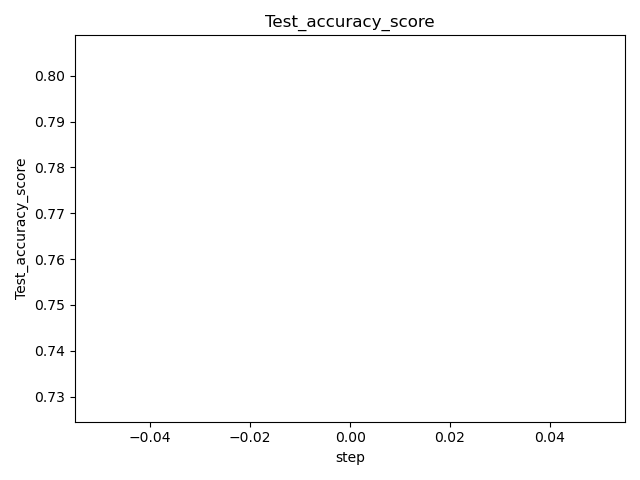

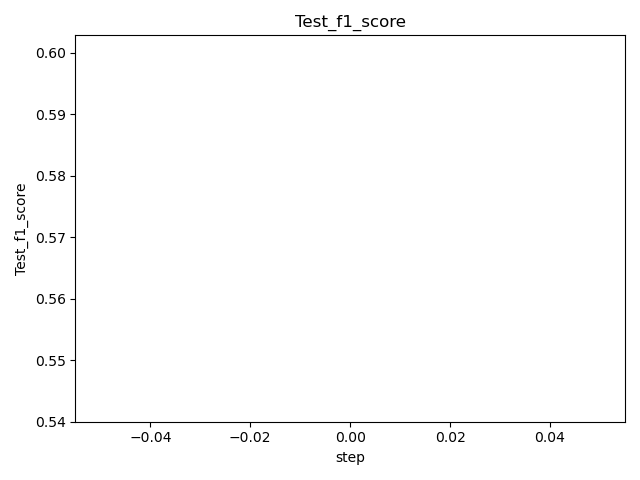

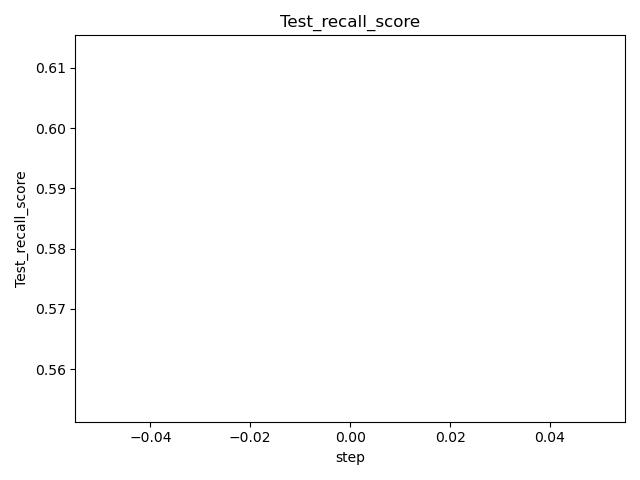

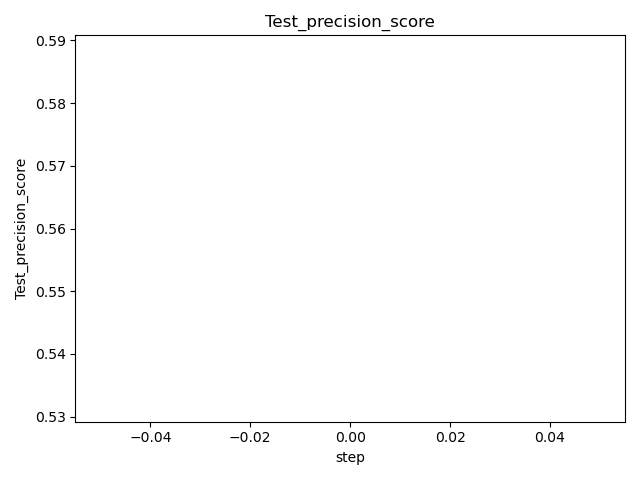

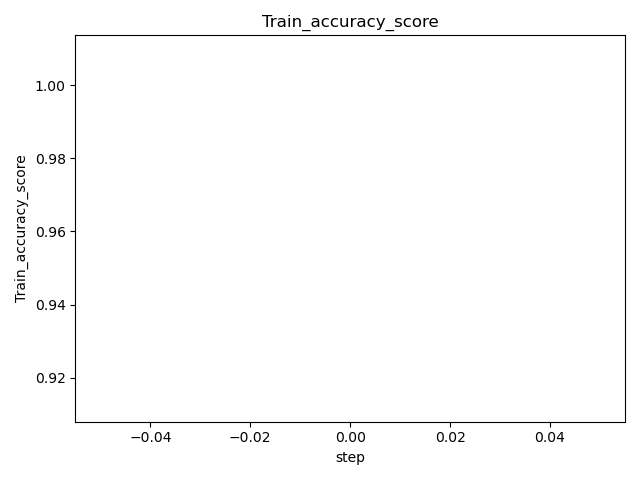

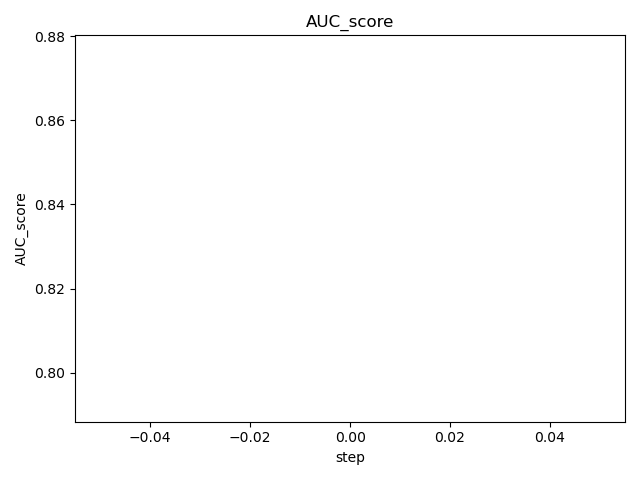



	.DS_Store, dvc_plots/index.html, .ipynb_checkpoints/demo-01-ChurnPrediction-checkpoint.ipynb, data/Customertravel_org.csv
/Users/loonycorn/anaconda3/lib/python3.10/site-packages/dvc_render/vega.py:98: UserWarning: `generate_markdown` can only be used with `LinearTemplate`
  warn("`generate_markdown` can only be used with `LinearTemplate`")


In [65]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier()
#rf_model = RandomForestClassifier(class_weight = 'balanced')
    
pipe_rf = Pipeline(steps = [('preprocessor', preprocessor), ('classifier', rf_model)])
model_params = rf_model.get_params()
print(model_params)
pipe_rf.fit(X_train, y_train)

predictions = pipe_rf.predict(X_test)
predictions_predict_prob = pipe_rf.predict_proba(X_test)
    
train_accuracy_score = pipe_rf.score(X_train, y_train)
test_accuracy_score = accuracy_score(y_test, predictions)
test_precision_score = precision_score(y_test, predictions)
test_recall_score = recall_score(y_test, predictions)
test_f1_score = f1_score(y_test, predictions)
auc_score = roc_auc_score(y_test,  predictions_predict_prob[:, 1])
    
metrics = {
        'Train_accuracy_score': train_accuracy_score, 
        'Test_accuracy_score': test_accuracy_score,
        'Test_precision_score': test_precision_score,
        'Test_recall_score': test_recall_score,
        'Test_f1_score': test_f1_score,
        'AUC_score': auc_score }
   
with Live(save_dvc_exp = True, report = 'notebook', exp_message = 'RFClassifier') as live:
    live.log_params(model_params)
        
    live.log_metric('Train_accuracy_score',train_accuracy_score)
    live.log_metric('Test_accuracy_score',test_accuracy_score)
    live.log_metric('Test_precision_score', test_precision_score)
    live.log_metric('Test_recall_score', test_recall_score)
    live.log_metric('Test_f1_score', test_f1_score)
    live.log_metric('AUC_score', auc_score)
    live.log_sklearn_plot('confusion_matrix', y_test, predictions, name = 'cm.json')
    

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


# DVC Report

params.yaml

| bootstrap   |   ccp_alpha | class_weight   | criterion   | max_depth   | max_features   | max_leaf_nodes   | max_samples   |   min_impurity_decrease |   min_samples_leaf |   min_samples_split |   min_weight_fraction_leaf |   n_estimators | n_jobs   | oob_score   | random_state   |   verbose | warm_start   |
|-------------|-------------|----------------|-------------|-------------|----------------|------------------|---------------|-------------------------|--------------------|---------------------|----------------------------|----------------|----------|-------------|----------------|-----------|--------------|
| True        |           0 | balanced       | gini        |             | sqrt           |                  |               |                       0 |                  1 |                   2 |                          0 |            100 |          | False       |                |         0 | False        |

metrics.json

|   Train_accuracy_score |   Test_accuracy_score |   Test_precision_score |   Test_recall_score |   Test_f1_score |   AUC_score |
|------------------------|-----------------------|------------------------|---------------------|-----------------|-------------|
|               0.960784 |              0.733333 |                    0.5 |            0.541667 |            0.52 |     0.81976 |

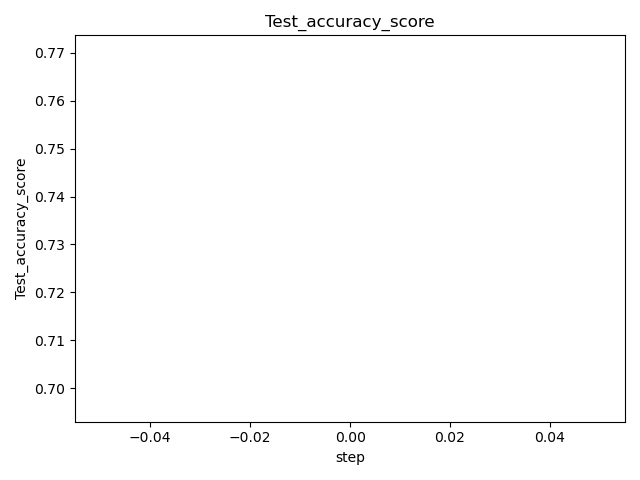

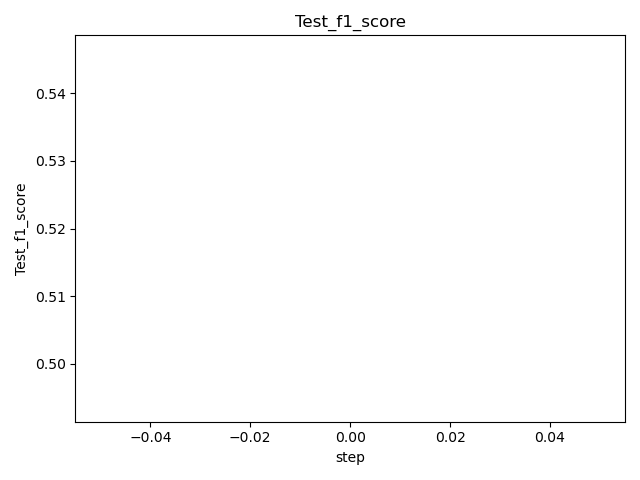

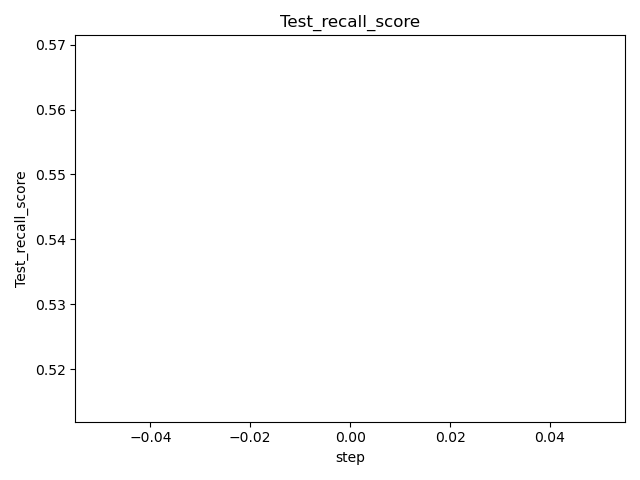

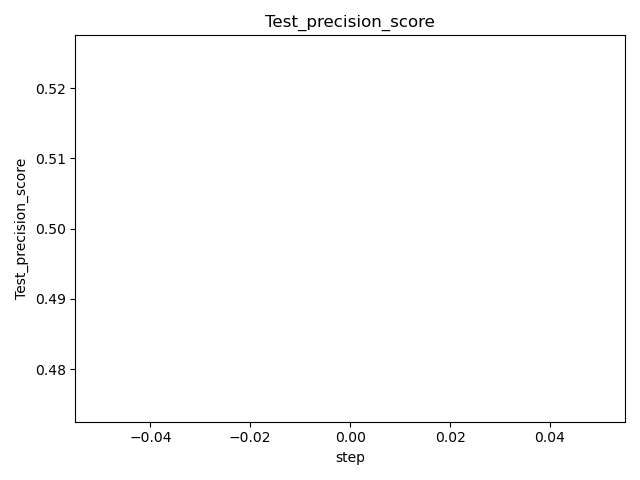

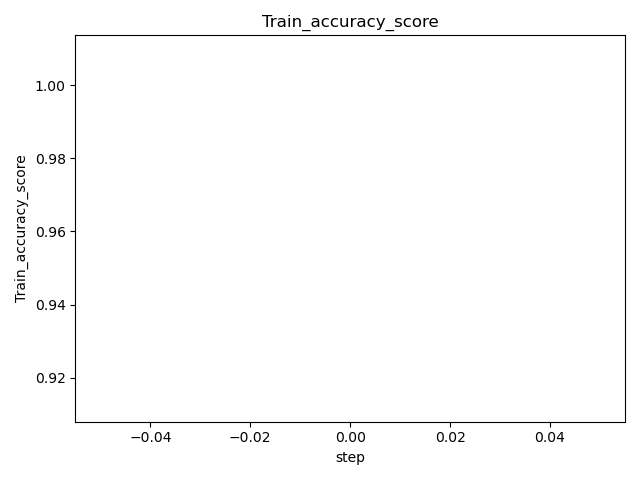

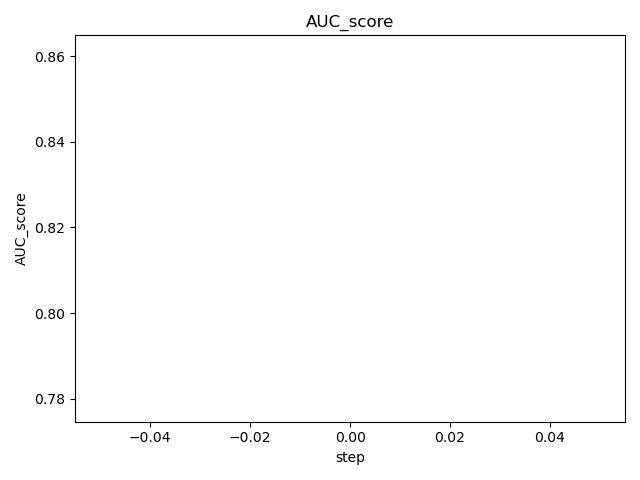



	.DS_Store, dvc_plots/index.html, .ipynb_checkpoints/demo-01-ChurnPrediction-checkpoint.ipynb, data/Customertravel_org.csv
/Users/loonycorn/anaconda3/lib/python3.10/site-packages/dvc_render/vega.py:98: UserWarning: `generate_markdown` can only be used with `LinearTemplate`
  warn("`generate_markdown` can only be used with `LinearTemplate`")


In [66]:
from sklearn.ensemble import RandomForestClassifier
#rf_model = RandomForestClassifier()
rf_model = RandomForestClassifier(class_weight = 'balanced')
    
pipe_rf = Pipeline(steps = [('preprocessor', preprocessor), ('classifier', rf_model)])
model_params = rf_model.get_params()
print(model_params)
pipe_rf.fit(X_train, y_train)

predictions = pipe_rf.predict(X_test)
predictions_predict_prob = pipe_rf.predict_proba(X_test)
    
train_accuracy_score = pipe_rf.score(X_train, y_train)
test_accuracy_score = accuracy_score(y_test, predictions)
test_precision_score = precision_score(y_test, predictions)
test_recall_score = recall_score(y_test, predictions)
test_f1_score = f1_score(y_test, predictions)
auc_score = roc_auc_score(y_test,  predictions_predict_prob[:, 1])
    
metrics = {
        'Train_accuracy_score': train_accuracy_score, 
        'Test_accuracy_score': test_accuracy_score,
        'Test_precision_score': test_precision_score,
        'Test_recall_score': test_recall_score,
        'Test_f1_score': test_f1_score,
        'AUC_score': auc_score }
   
with Live(save_dvc_exp = True, report = 'notebook', exp_message = 'RFClassifier_balanced_class_weight') as live:
    live.log_params(model_params)
        
    live.log_metric('Train_accuracy_score',train_accuracy_score)
    live.log_metric('Test_accuracy_score',test_accuracy_score)
    live.log_metric('Test_precision_score', test_precision_score)
    live.log_metric('Test_recall_score', test_recall_score)
    live.log_metric('Test_f1_score', test_f1_score)
    live.log_metric('AUC_score', auc_score)
    live.log_sklearn_plot('confusion_matrix', y_test, predictions, name = 'cm.json')

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


# DVC Report

params.yaml

| bootstrap   |   ccp_alpha | class_weight   | criterion   | max_depth   | max_features   | max_leaf_nodes   | max_samples   |   min_impurity_decrease |   min_samples_leaf |   min_samples_split |   min_weight_fraction_leaf |   n_estimators | n_jobs   | oob_score   | random_state   |   verbose | warm_start   |
|-------------|-------------|----------------|-------------|-------------|----------------|------------------|---------------|-------------------------|--------------------|---------------------|----------------------------|----------------|----------|-------------|----------------|-----------|--------------|
| True        |           0 |                | gini        |             | sqrt           |                  |               |                       0 |                  1 |                   2 |                          0 |            100 |          | False       |                |         0 | False        |

metrics.json

|   Train_accuracy_score |   Test_accuracy_score |   Test_precision_score |   Test_recall_score |   Test_f1_score |   AUC_score |
|------------------------|-----------------------|------------------------|---------------------|-----------------|-------------|
|               0.960784 |              0.744444 |               0.521739 |                 0.5 |        0.510638 |    0.827967 |

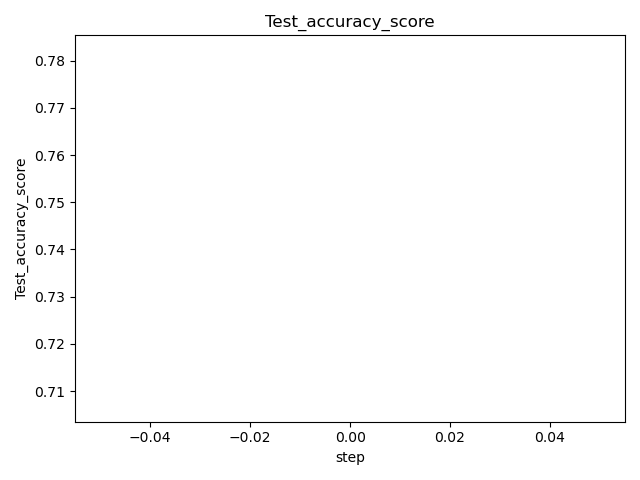

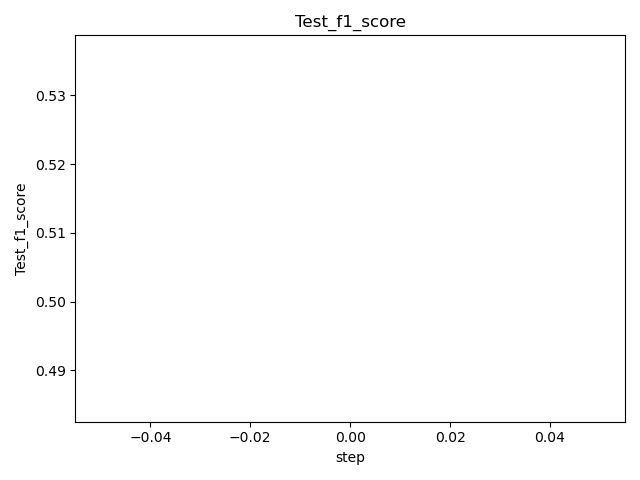

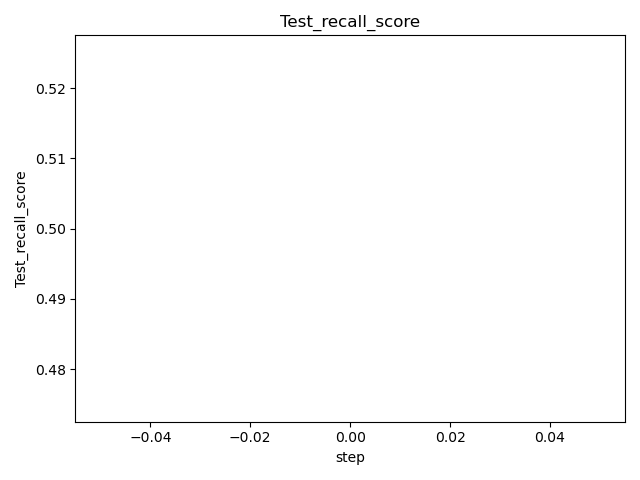

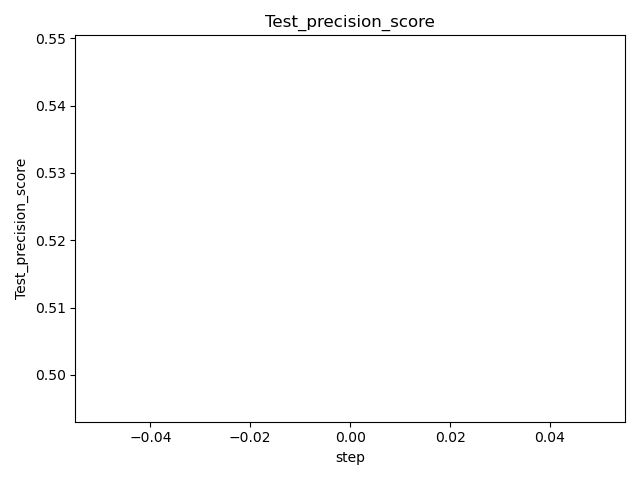

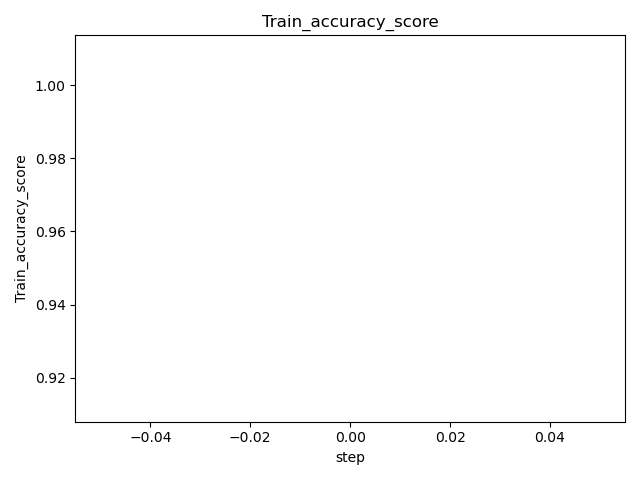

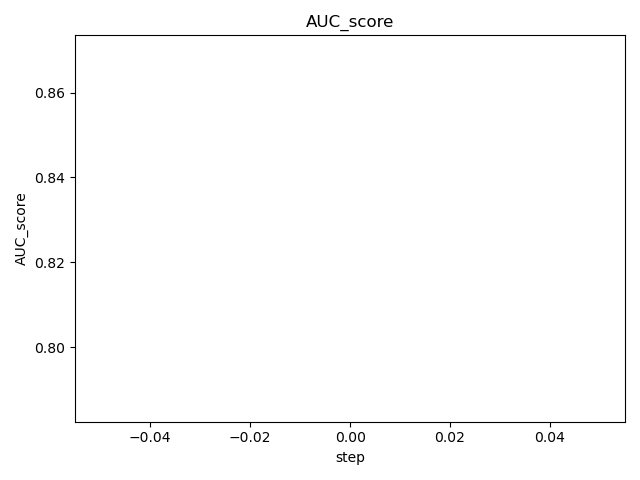



	.DS_Store, dvc_plots/index.html, .ipynb_checkpoints/demo-01-ChurnPrediction-checkpoint.ipynb, data/Customertravel_org.csv
/Users/loonycorn/anaconda3/lib/python3.10/site-packages/dvc_render/vega.py:98: UserWarning: `generate_markdown` can only be used with `LinearTemplate`
  warn("`generate_markdown` can only be used with `LinearTemplate`")


In [50]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier()
#rf_model = RandomForestClassifier(class_weight = 'balanced')
    
pipe_rf = Pipeline(steps = [('preprocessor', preprocessor), ('classifier', rf_model)])
model_params = rf_model.get_params()
print(model_params)
pipe_rf.fit(X_train, y_train)

predictions = pipe_rf.predict(X_test)
predictions_predict_prob = pipe_rf.predict_proba(X_test)
    
train_accuracy_score = pipe_rf.score(X_train, y_train)
test_accuracy_score = accuracy_score(y_test, predictions)
test_precision_score = precision_score(y_test, predictions)
test_recall_score = recall_score(y_test, predictions)
test_f1_score = f1_score(y_test, predictions)
auc_score = roc_auc_score(y_test,  predictions_predict_prob[:, 1])
    
metrics = {
        'Train_accuracy_score': train_accuracy_score, 
        'Test_accuracy_score': test_accuracy_score,
        'Test_precision_score': test_precision_score,
        'Test_recall_score': test_recall_score,
        'Test_f1_score': test_f1_score,
        'AUC_score': auc_score }
   
with Live(save_dvc_exp = True, report = 'notebook', exp_message = 'RFClassifier_default_params') as live:
    live.log_params(model_params)
        
    live.log_metric('Train_accuracy_score',train_accuracy_score)
    live.log_metric('Test_accuracy_score',test_accuracy_score)
    live.log_metric('Test_precision_score', test_precision_score)
    live.log_metric('Test_recall_score', test_recall_score)
    live.log_metric('Test_f1_score', test_f1_score)
    live.log_metric('AUC_score', auc_score)
    live.log_sklearn_plot('confusion_matrix', y_test, predictions, name = 'cm.json')

In [68]:
from sklearn.svm import SVC

svc_model = SVC(class_weight = 'balanced')
    
pipe_svc = Pipeline(steps = [('preprocessor', preprocessor), ('classifier', svc_model )])
pipe_svc.fit(X_train, y_train)
model_params = svc_model.get_params()
print(model_params)
predictions =  pipe_svc.predict(X_test)
    
train_accuracy_score = pipe_svc.score(X_train, y_train)
test_accuracy_score = accuracy_score(y_test, predictions)
test_precision_score = precision_score(y_test, predictions)
test_recall_score = recall_score(y_test, predictions)
test_f1_score = f1_score(y_test, predictions)
    
metrics = {
        'Train_accuracy_score': train_accuracy_score, 
        'Test_accuracy_score': test_accuracy_score,
        'Test_precision_score': test_precision_score,
        'Test_recall_score': test_recall_score,
        'Test_f1_score': test_f1_score}
   
with Live(save_dvc_exp = True, exp_message = 'SVClassifier_class_weight_balanced') as live:
    live.log_params(model_params)
        
    live.log_metric('Train_accuracy_score', train_accuracy_score)
    live.log_metric('Test_accuracy_score', test_accuracy_score)
    live.log_metric('Test_precision_score', test_precision_score)
    live.log_metric('Test_recall_score', test_recall_score)
    live.log_metric('Test_f1_score', test_f1_score)
    live.log_sklearn_plot('confusion_matrix', y_test, predictions, name = 'cm.json')

{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': 'balanced', 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


	.DS_Store, dvc_plots/index.html, .ipynb_checkpoints/demo-01-ChurnPrediction-checkpoint.ipynb, data/Customertravel_org.csv


In [48]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [77]:
from xgboost.sklearn import XGBClassifier
#xgb_model = XGBClassifier()
xgb_model = XGBClassifier(scale_pos_weight=2)
    
pipe_xgb = Pipeline(steps = [('preprocessor', preprocessor), ('classifier', xgb_model )])
pipe_xgb.fit(X_train, y_train)
model_params = xgb_model.get_params()
print(model_params)
predictions =  pipe_xgb.predict(X_test)
predictions_predict_prob = pipe_xgb.predict_proba(X_test)
    
train_accuracy_score = pipe_xgb.score(X_train, y_train)
test_accuracy_score = accuracy_score(y_test, predictions)
test_precision_score = precision_score(y_test, predictions)
test_recall_score = recall_score(y_test, predictions)
test_f1_score = f1_score(y_test, predictions)
auc_score = roc_auc_score(y_test,  predictions_predict_prob[:, 1])
    
metrics = {
        'Train_accuracy_score': train_accuracy_score, 
        'Test_accuracy_score': test_accuracy_score,
        'Test_precision_score': test_precision_score,
        'Test_recall_score': test_recall_score,
        'Test_f1_score': test_f1_score,
        'AUC_score': auc_score }
   
with Live(save_dvc_exp = True, exp_message = 'XGBoostingClassifier') as live:
    live.log_params(model_params)
        
    live.log_metric('Train_accuracy_score', train_accuracy_score)
    live.log_metric('Test_accuracy_score', test_accuracy_score)
    live.log_metric('Test_precision_score', test_precision_score)
    live.log_metric('Test_recall_score', test_recall_score)
    live.log_metric('Test_f1_score', test_f1_score)
    live.log_metric('AUC_score', auc_score)
    live.log_sklearn_plot('confusion_matrix', y_test, predictions, name = 'cm.json')

{'objective': 'binary:logistic', 'use_label_encoder': None, 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': 2, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


	.DS_Store, dvc_plots/index.html, .ipynb_checkpoints/demo-01-ChurnPrediction-checkpoint.ipynb, data/Customertravel_org.csv


In [71]:
pip install optuna

     l     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/390.6 kB ? eta -:--:--━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/390.6 kB 2.2 MB/s eta 0:00:01━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━ 245.8/390.6 kB 3.0 MB/s eta 0:00:01━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 389.1/390.6 kB 3.5 MB/s eta 0:00:01━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 2.8 MB/s eta 0:00:00
     l     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/224.5 kB ? eta -:--:--━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 8.9 MB/s eta 0:00:00
     l     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/78.7 kB ? eta -:--:--━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 3.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [18]:
from xgboost.sklearn import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [53]:
def objective(trial):
    """Define the objective function"""

    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 15, log = True),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log = True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500, log = True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10, log = True),
    }

    # Fit the model
    xgb_model = RandomForestClassifier(**params)
    
    pipe_xgb = Pipeline(steps = [('preprocessor', preprocessor), ('classifier', xgb_model )])
    pipe_xgb.fit(X_train, y_train)

    # Make predictions
    predictions = pipe_xgb.predict(X_test)

    # Evaluate predictions
    f1 = f1_score(y_test, predictions)
    return f1

In [13]:
from dvclive.optuna import DVCLiveCallback

In [14]:
import optuna
study = optuna.create_study(direction = 'maximize')

[I 2023-06-21 10:24:12,168] A new study created in memory with name: no-name-d09e4c38-2a17-4593-b401-f1663563f66d


In [19]:
study.optimize(objective, n_trials = 32, callbacks = [DVCLiveCallback()])

[I 2023-06-21 10:26:38,596] Trial 2 finished with value: 0.30303030303030304 and parameters: {'max_depth': 1, 'learning_rate': 0.05391390107686825, 'n_estimators': 118, 'min_child_weight': 4, 'lambda': 0.9674124058442086, 'alpha': 1.7441574209848694}. Best is trial 2 with value: 0.30303030303030304.
	.DS_Store, dvc_plots/index.html, .ipynb_checkpoints/demo-01-ChurnPrediction-checkpoint.ipynb, dvclive/.DS_Store, dvclive/report.md, dvclive/dvc.yaml, dvclive/report.html, dvclive/static/Test_accuracy_score.png, dvclive/static/Test_precision_score.png, dvclive/static/Train_accuracy_score.png, dvclive/static/AUC_score.png, dvclive/static/Test_f1_score.png, dvclive/static/Test_recall_score.png, data/Customertravel_org.csv
[I 2023-06-21 10:26:43,386] Trial 3 finished with value: 0.48780487804878053 and parameters: {'max_depth': 13, 'learning_rate': 0.4218244697909161, 'n_estimators': 167, 'min_child_weight': 1, 'lambda': 6.631984136773236, 'alpha': 5.870756875477388}. Best is trial 3 with valu

	.DS_Store, dvc_plots/index.html, .ipynb_checkpoints/demo-01-ChurnPrediction-checkpoint.ipynb, dvclive/.DS_Store, dvclive/report.md, dvclive/dvc.yaml, dvclive/report.html, dvclive/static/Test_accuracy_score.png, dvclive/static/Test_precision_score.png, dvclive/static/Train_accuracy_score.png, dvclive/static/AUC_score.png, dvclive/static/Test_f1_score.png, dvclive/static/Test_recall_score.png, data/Customertravel_org.csv
[I 2023-06-21 10:27:14,610] Trial 22 finished with value: 0.6122448979591836 and parameters: {'max_depth': 8, 'learning_rate': 0.674757691845111, 'n_estimators': 374, 'min_child_weight': 10, 'lambda': 3.9007713202235275, 'alpha': 0.4096958428024218}. Best is trial 21 with value: 0.64.
	.DS_Store, dvc_plots/index.html, .ipynb_checkpoints/demo-01-ChurnPrediction-checkpoint.ipynb, dvclive/.DS_Store, dvclive/report.md, dvclive/dvc.yaml, dvclive/report.html, dvclive/static/Test_accuracy_score.png, dvclive/static/Test_precision_score.png, dvclive/static/Train_accuracy_score.p

In [20]:
print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Number of finished trials: 34
Best trial:
  Value: 0.6923076923076924
  Params: 
    max_depth: 6
    learning_rate: 0.5971986597958563
    n_estimators: 395
    min_child_weight: 7
    lambda: 4.372372141676682
    alpha: 0.9626223508109106


In [21]:
params = trial.params

In [23]:
xgb_model = XGBClassifier(**params)
    
pipe_xgb = Pipeline(steps = [('preprocessor', preprocessor), ('classifier', xgb_model )])
pipe_xgb.fit(X_train, y_train)

    # Make predictions
predictions = pipe_xgb.predict(X_test)

In [30]:
print('Test accuracy score :',accuracy_score(y_test, predictions))
print('Test precision score :', precision_score(y_test, predictions))
print('Test recall score :' , recall_score(y_test, predictions))
print('Test f1 score :', f1_score(y_test, predictions))
#auc_score = roc_auc_score(y_test,  predictions_predict_prob[:, 1])

Test accuracy score : 0.8222222222222222
Test precision score : 0.6428571428571429
Test recall score : 0.75
Test f1 score : 0.6923076923076924


In [31]:
X_train

Age FrequentFlyer  AnnualIncomeClass  ServicesOpted  \
166   30     No Record                  0              1   
928   28            No                  0              1   
222   30            No                  1              5   
847   31            No                  0              2   
359   27            No                  1              2   
..   ...           ...                ...            ...   
544   34            No                  0              1   
205   31           Yes                  0              1   
157   30           Yes                  0              5   
17    30           Yes                  2              1   
188   28     No Record                  1              4   

    AccountSyncedToSocialMedia BookedHotelOrNot  
166                        Yes               No  
928                        Yes              Yes  
222                        Yes              Yes  
847                        Yes               No  
359                         No               No  
..                         ...              ...  
544                         No              Yes  
205                         No              Yes  
157                        Yes               No  
17                         Yes               No  
188                         No               No  

[357 rows x 6 columns]

In [33]:
pip install mlem

  Using cached mlem-0.4.13-py3-none-any.whl (218 kB)
  Using cached python_multipart-0.0.6-py3-none-any.whl (45 kB)
  Using cached cached_property-1.5.2-py2.py3-none-any.whl (7.6 kB)
  Using cached pydantic-1.10.9-cp310-cp310-macosx_10_9_x86_64.whl (2.9 MB)
  Using cached flatdict-4.0.1.tar.gz (8.3 kB)
  Preparing metadata (setup.py) ... done
  Using cached isort-5.12.0-py3-none-any.whl (91 kB)
  Using cached aiohttp_swagger-1.0.16-py3-none-any.whl (3.3 MB)
  Using cached python_gitlab-3.15.0-py3-none-any.whl (135 kB)
  Using cached typer-0.9.0-py3-none-any.whl (45 kB)
  Using cached requests_toolbelt-1.0.0-py2.py3-none-any.whl (54 kB)
  Created wheel for flatdict: filename=flatdict-4.0.1-py3-none-any.whl size=6929 sha256=c36210e65186a9c367702a00177e885d3c16ccd5163ae68ad6c86bdc4d62bbf3
  Stored in directory: /Users/loonycorn/Library/Caches/pip/wheels/5d/01/72/b5541b1fbf6e3ec5a4fb0cfc6cb0af465d2024ff00721f3a73
Successfully built flatdict
  Attempting uninstall: isort
    Found existing 

In [52]:
from mlem.api import save

# instead of joblib.dump(rf, "models/rf")
save(pipe_xgb, "models/pipe_xgb", sample_data = X_train)

MlemModel(location=Location(path='/Users/loonycorn/CustomerChurnPredictionProject/models/pipe_xgb.mlem', project=None, rev=None, uri='file:///Users/loonycorn/CustomerChurnPredictionProject/models/pipe_xgb.mlem', project_uri=None, fs=<fsspec.implementations.local.LocalFileSystem object at 0x7fea37545210>), params={}, artifacts={'data': LocalArtifact(uri='pipe_xgb', size=299890, hash='9310396fdd1c1656a2e23b63c38fc0c8')}, requirements=Requirements(__root__=[InstallableRequirement(module='pandas', version='1.5.3', package_name=None, extra_index=None, source_url=None, vcs=None, vcs_commit=None), InstallableRequirement(module='sklearn', version='1.2.1', package_name='scikit-learn', extra_index=None, source_url=None, vcs=None, vcs_commit=None), CustomRequirement(module='numpy', name='numpy', source64zip='eJxsm8eu61xyRl/F6CntZk4GeiDmTIqZnPxgzjnTL29dw3Z7YEACNDkU995VX61F6PzH38ZjmB/wr/nZi23/8y7Wv89P87d//5e/FcojeJmwXO9HP8tttXksz63hc0lRxunaFKW505qafCUcf/uayp4nhuRk0IbRVX0BZ9xxshsRVSdb2eVxLlRd4fLEqH3

In [49]:
X_test.iloc[10].values

array([38, 'Yes', 2, 4, 'No', 'No'], dtype=object)

In [41]:
predictions

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1])

In [40]:
y_test

385    0
890    1
115    0
386    0
168    0
      ..
426    0
52     0
794    0
103    1
570    0
Name: Target, Length: 90, dtype: int64

In [51]:
from mlem.api import load

model = load('models/pipe_xgb')  
features = ['Age', 'FrequentFlyer', 'AnnualIncomeClass', 'ServicesOpted',
            'AccountSyncedToSocialMedia', 'BookedHotelOrNot']
df = pd.DataFrame([[38, 'Yes', 2, 4, 'No', 'No']], columns = features)
y_pred = model.predict(df)

print(y_pred)

[1]
